# The Finite Element Method

The Finite Element Method (FEM) is a very popular method with a wide range of applications. It is an *integral* technique, similar to the Finite Volume Method which provide it with a number of benefits.  

* Complex geometries
* Irregular meshing
* Irregular material properties
* Options to tweak the method according to the physics
* (quasi)dynamic mesh refinement
* Highly flexible boundary conditions
* Ability to solve *boundary physics*
* Excellent accuracy

## Illustrative example

Consider an ODE $ y^\prime = -y \quad y(0) = 1$, which has an analytical answer $y = e^{-t}$.

We wish to approximate this function numerically between $[0,1]$ with a line defined by the boundary points, $f(0) = a = 1$ and $f(1) = b$, $$f(x) =  [1-x] + x b$$

How do we find $b$?

### Option 1: Direct substitution

Following the Finite Difference method, we can subsitute $f(1)$ into the ODE and solve for b:

$$\begin{align}
f'(1) &= f(1) \\
b-1 &= -b \\
b &= 1/2
\end{align}$$
and the approximate solution is $f = 1 -\frac{x}{2}$



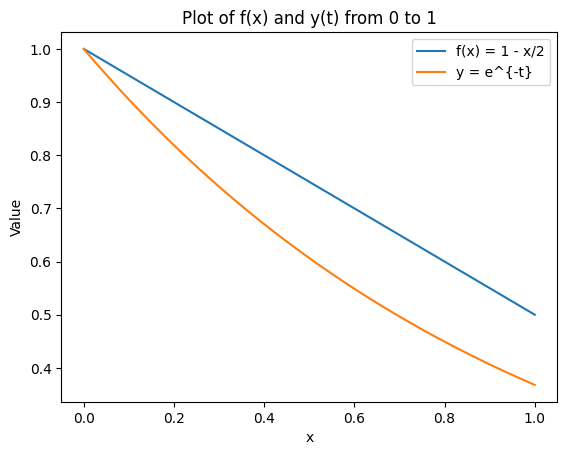

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
f = lambda x: 1 - x / 2
y = lambda t: np.exp(-t)

# Generate values
x = np.linspace(0, 1, 100)
f_values = f(x)
y_values = y(x)

# Plot the functions
plt.plot(x, f_values, label='f(x) = 1 - x/2')
plt.plot(x, y_values, label='y = e^{-t}')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.title('Plot of f(x) and y(t) from 0 to 1')
plt.show()

### Option 2: Least square minimization of the residual

Let's integrate the squared residual of f(x) plugged into the ODE, $y^\prime + y$

$$\begin{align}
R &= f^\prime(x) +f(x) \\
&= [b-1] + 1-x + x b \\
&= b+x[b-1] \\
R^2 &= b^2 + 2 b x[b - 1] + [x[b - 1]]^2 \\
F = \int_0^1 R^2 \ dx &= \frac{1}{3} [7 b^2 - 5 b + 1] \\
\end{align} $$

Note that in the end the integral of the residual, $F$ is a parabolic function of the parameter $b$. The minimum is found at:
$\frac{\partial F}{\partial b}(b) = 0$, for $b = \frac{5}{14}$. The approximate solution is $f(x) = 1-\frac{9}{14}x$.

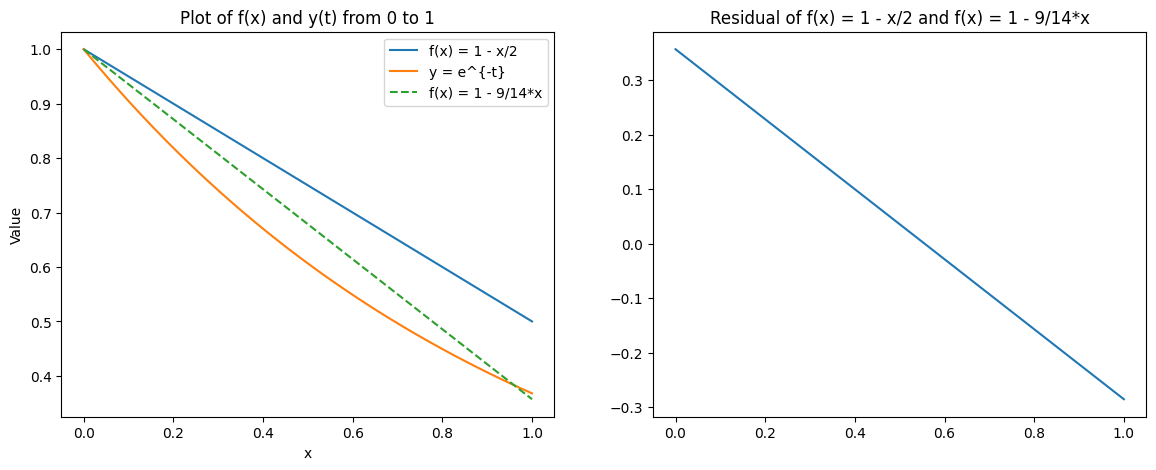

In [2]:
# Define the new function
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
f_new = lambda x: 1 - 9./14*x
f_new_values = f_new(x)


# Plot the functions
axs[0].plot(x, f_values, label='f(x) = 1 - x/2')
axs[0].plot(x, y_values, label='y = e^{-t}')
axs[0].plot(x, f_new_values, label='f(x) = 1 - 9/14*x', linestyle='--')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Value')
axs[0].legend()
axs[0].set_title('Plot of f(x) and y(t) from 0 to 1')

# Plot the residual
residual = lambda x: -9/14 + 1 - 9./14*x
axs[1].plot(x, residual(x))
axs[1].set_title('Residual of f(x) = 1 - x/2 and f(x) = 1 - 9/14*x')

plt.show()

We see that option 2 does a better job of approximating the function over the full domain since it focusses on the integral of the residual.

You may have noticed that we did something funny here: we integrated $R^2$ and then took its derivative with respect to $b$ in order to find the minimum of the integral! I.e.:

$$\begin{align}
\frac{\partial F}{\partial b} = 0 &= \frac{\partial }{\partial b} \int_0^1 R^2 \ dx  \\
&= \int_0^1 2R \frac{\partial R}{\partial b}  \ dx \\
&= \int_0^1 R v  \ dx
\end{align} $$

where the residual has now been weighted by the function $v$. This is called the Method of Weighted Residual [MWR]. Let's try a different function and see what happens.

### Option 3: Integrate the MWR to find the parameters

Integrate the weighted residual function directly with a convenient choice of $v$.

lets take $v = x$ (to be motivated later) and integrate:

$$\begin{align}
\frac{\partial F}{\partial b} =0 &= \int_0^1 R x  \ dx \\
&= \int_0^1 \big[b+[b-1]x\big]x  \ dx \\
&= \int_0^1 b x+[b-1]x^2  \ dx \\
&= \bigg[ \frac{1}{6} x^2\big[3b+2[b-1]x\big]\bigg]_0^1 \\
&= b-\frac{2}{5} \\
\end{align} $$

which is very close to our previous solution $b = \frac{5}{14}$ but with a simpler integration. BUT, we are still let with analytically integrating! If only there were a way to express integrals as the sum of the integrand evaluated at certain points...

### Option 4: Express the MWR integral as the sum of the integrand evaluated at certain points.

Integrate the weighted residual function directly with a convenient choice of $v$ as the sum of the integrand evaluated at certain points:

Recall Gaussian Quadrature allows us to evaluate an integral by summing the integrand at the Gauss Points. The Gauss Points for the domain $[-1,1]$ are $\pm\frac{1}{\sqrt{3}}$, scaled to this integral domain become,


$$ \begin{align}
x_{[0,1]]} &= 0.5 (x_{[-1,1]} + 1) \\
&= \frac{1}{2} \bigg[1 \pm\frac{1}{\sqrt{3}} \bigg] \\
&\approx [0.21132487, 0.78867513]
\end{align} $$

and

$$\begin{align}
0 &= \int_0^1 R x  \ dx \\
&= Rx (x=.21132487) + Rx(x = .78867513) \\
&= -0.0446582 + 0.255983 b  -0.622008 + 1.41068 b \\
b &= \frac{2}{5}
\end{align} $$

### Recap of the approach

Let's recap what we've done:

1. parameterized a function as a weighted sum of simpler functions (a linear basis)
2. found a (simple) integral expression that minimizes the error in the approxiation (Minimized Weighted Residual)
3. performed the integration *exactly* using only function evaluations into a linear system (Gaussian quadrature)
4. Solved the linear system (I **told** you everything boiled down to linear systems!)

Practical solution of linear systems requires sparsity! Let's formalize our proceedure and see how we can ensure sparsity.

## Derivation of the finite element method BVPs

Consider a  differential equation,
$$ \mathcal{L}(u) = f \quad \text{in } \Omega, $$

in one dimension for convenience.

** Boundary conditions in $\partial \Omega$?

where:
* $\mathcal{L}$ is a differential operator
* $u(x)$ is the unknown *exact* solution
* $f(x)$ is a given source term dependant only on space.
* $\Omega$ is the ND domain of the problem, with boundary $\partial \Omega$.

Define the residual,
$$ R(u) = \mathcal{L}(u) - f$$
For the exact solution, $R(u) = 0$ everywhere in $\Omega$.

### Approximate the solution with *shape functions*

In liue of an exact solution, we will have to settle for an approximate solution, $u_h$, for which $R(u_h) \ne 0$ but will be made as small as possible. As discussed in the Interpolation sections, a function can be approximated as a weighted sum of basis functions:

$$ \begin{align}
u_h(x) &= \sum_{i=1}^N w_i \phi_i(x) \\
\end{align}$$

Where:
* $w_i$ are the weights / coefficients of the approximation
* $\phi_i(x)$ are a set of suitable *shape functions*.

It is trivial to see that,
$$ \nabla u_h = \sum_i w_i \nabla \phi_i $$

### Minimizing the residual with the *Method of Weighted Residuals*

The best approximation will minimize the residual everywhere in $\Omega$. In previous work (e.g.: curve fit) we minimzed the square of the residual, but here we will use the Method of Weighted Residuals:

$$ \int_\Omega R v \  dx = 0 $$

The MWR is a *weaker* statement of minimization.
$v(x)$ is a *test* function for which we have options.


#### $v = 2\frac{\partial R}{\partial w_i}$ : Least Squares

If we take $v = 2\frac{\partial R}{\partial w_i}$,

$$ \begin{align}
\int_\Omega R \frac{\partial R}{\partial w_i} d\Omega &= 0 \\
\frac{\partial }{\partial w_i} \int_\Omega R^2 d\Omega &= 0
\end{align}$$

which is exactly the condition for finding the parameters for Least Squares minimization.

#### $v = \delta (x) $: Collocation methods

If $v = \delta (x)$ then for a discrete set of points $x_i$, the integral turns into a sum:

$$ \begin{align}
\int_\Omega R \delta(x_i) d\Omega &= 0 \\
\sum_i R(x_i) = 0
\end{align}$$

which requires that the residual be zero at all discretization points (the collocation method).

#### $v = \sum_i \phi_i$: The Galerkin method

The Galerkin method chooses the test functions to be in the same basis as the solution $u_h = \sum_i w_i \phi_i$.

$$ \begin{align}
\int_\Omega R v \  d\Omega &= 0 \\
\sum_i \int_\Omega R \phi_i \  d\Omega &= 0
\end{align}$$

Why does this work? Note that the MWR is an expression of orthogonality between $R$ and $v$. What this means is that the residual has no component in the space defined by the basis functions, or more simply, it can't be improved by changing the weights $w_i$. This is a more general expression for the minimum which is more in line with our discrete / numerical approach. It also opens avenues to choose $\phi_i$ carefully for computational efficiency!



### The weak form

Our usual formulation of BVPs is called the *strong* form because it assumes a lot of continuity in a solution. E.g.: if the equation contains $\nabla^2 u$, the solution assumes that that derivative exists!

The MWR leads to the *weak form* which has less requirements on the solution, amoungst other benefits. Essentially, all we have to do is multiply through by our test function $v$ and integrate. Something *very* useful happens to our divergence-of-flux terms, which are prevelant in conservation equations.

As an example, consider a time dependant heat balance (temperature = $u$), using the backward Euler time marching scheme.
$$ \begin{align}
\frac{\partial u}{\partial t} &= -\nabla \cdot \vec{J} \\
\frac{u - u^{t-1}}{\Delta t} &= -\nabla \cdot \vec{J} \\
u + \Delta t [\nabla \cdot \vec{J}] &= u^{t-1}
\end{align}$$


To get to the weak form, multiply through by the test funciton $v$ and integrate:  

$$ 0 = \int_{\Omega} u v - \int_{\Omega} u^{t-1}v \  + \Delta t \int_{\Omega}v \nabla \cdot \vec{J} $$

Examining the divergence-of-flux term, we see that we can apply integration by parts followed by the Divergence Theorem:
$$ \begin{align}
\int_\Omega v \nabla \cdot \vec{J}  &= -\int_\Omega \nabla v \cdot \vec{J}  + \int_{\Omega} \nabla \cdot \big[v\vec{J}\big]  \\
&=-\int_\Omega \nabla v \cdot \vec{J}  + \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n} \\
&=\int_\Omega \lambda \nabla v \nabla u  + \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n}    
\end{align}$$

which is remarkable since we:

* replaced a second derivative with the product of two first derivatives.
* no longer require our solution to *have* a second derivative (it can be less smooth and satisfy the equation in an average sense which is *weaker* than the *strong* form)!
* incorporated boundary fluxes directly into the residual calculation (through the surface integral)
* do not require anything from $\lambda$, which means this is still valid for $\lambda(u,x,t...)$, however it is now outside of the gradient!
* We also provided an avenue for directly integrating surface *phenomena* into our model through the surface integral!)




The weak form of the equation becomes (collecting all unknowns on the fight hand side),

$$ \begin{align}
\int_{\Omega} u v + \Delta t \int_\Omega \lambda \nabla v \nabla u   + \Delta t \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n} &= \int_{\Omega} u^{t-1}v \\
\end{align}$$




## Discretization

We are now in a position to discretize the equation into a form we are able to solve, which will (finally) give us an idea of what the shape functions are.

### Meshing the domain

The geometry of the problem can generally be complex, with curved boundaries separating adjacent domains. Additionally, we may want different spatial resolution at different points in our model to capture gradients or differeing material properties.

The Finite Element Method partitions the domain into a *Finite* set of *Elements* through tesselation (space filling tiling). This meshing proceedure is actually very complex and there are sophisticated, dedicated software packages e.g., Cubit  (commercial), GMSH (open source), etc.

The most flexible element in 2D is triangular, but quadralateral elements are also popular. In 3D, tetrahedra are common, triangular prisms or rectangular prisms are also admissable.

Elements may be mixed to better capture features. E.g.: in Computational Fluid Dynamics one may use square boundary layers along a surface and then triangles in the stream.

One does have to be wary of degeneracy where one side is small compared to the others, which can lead to poor numerical performance.


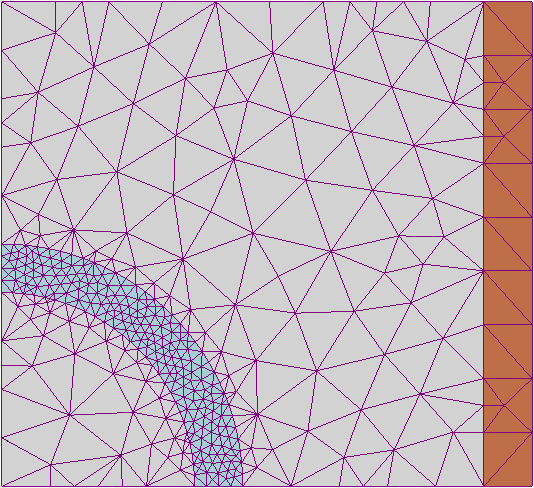

Notice how each mesh cell is a scaled, translated version of the same reference cell.

### Small support for shape functions

The shape functions are generally designed to be non-zero only inside their element. This has the effect of limiting products, $\int \phi_i \phi_j$ , $\int \nabla \phi_i \nabla \phi_j$ to be zero for all combination of $i$ and $j$ except for cases where $i$ and $j$ are within the same element which results in sparse matricies!

## Assembly

$u = \sum u_i \phi_i$


$$\begin{align}
\int_{\Omega} uv  &= \sum_i u_i \int_{\Omega} \phi_i \phi_j
&=  u_i M_{ij}
\end{align}$$

Similarly,

$$\begin{align} \int_\Omega \lambda \nabla v \nabla u &= \sum_i \lambda(u_i) u_i \int_{\Omega} \nabla \phi_i \nabla \phi_j \\
&=  \lambda(u_i) u_i K_{ij}
\end{align}$$
which is called the *stiffness matrix*.

The term
$$\begin{align}
\int_{\Omega} u^{t-1} v &= u_i^{t-1} M_{ij} = b_i
\end{align}$$
but can also be calculated directly since $u_i^{t-1}$ is known.
                               



Finally we can assemble our equation:

$$ \begin{align}
\int_{\Omega} u v + \Delta t \int_\Omega \lambda \nabla v \nabla u   &= \int_{\Omega} u^{t-1}v - \Delta t \int_{\partial \Omega} v \ \vec{J} \cdot \hat{n}\\
u_i M_{ij} + \Delta t \lambda u_i K_{ij}  &= b_i - J_n \\
\end{align}$$

| **Weak Form Term**                                    | **Matrix Form (FEM)**                                                                                     | **Description**                                                                 |
|-------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| $\int_\Omega \phi_i \phi_j \, d\Omega$               | $\mathbf{M}_{ij} = \int_\Omega \phi_i \phi_j \, d\Omega$                                                  | Mass matrix. Often used in time-dependent problems.                            |
| $\int_\Omega \nabla \phi_i \cdot \nabla \phi_j \, d\Omega$ | $\mathbf{K}_{ij} = \int_\Omega \nabla \phi_i \cdot \nabla \phi_j \, d\Omega$                               | Stiffness matrix. Used in problems like Poisson or elasticity equations.       |
| $\int_\Omega \phi_i f \, d\Omega$                    | $\mathbf{F}_i = \int_\Omega \phi_i f \, d\Omega$                                                          | Load vector. Represents source terms in the governing equation.                |
| $\int_{\partial \Omega} \phi_i g \, d\Gamma$         | $\mathbf{F}_i^{\text{bc}} = \int_{\partial \Omega} \phi_i g \, d\Gamma$                                   | Boundary load vector (from Neumann boundary conditions).                       |


## Solution

We now arrive at a matrix equation for the unknows $u_i$, which is mearly a system of equations as we've spoken about beforehand.

### Linear PDE

If the PDE is linear, we can solve it with a linear solver which is sparse due to the small support requirement of the elements. The matrix will not in general be banded however, due to the irregular conectivity of the mesh verticies.

#### Example: 1D heat equation

Solve the 1D heat balance equation with $\lambda = 1$ for $x$ from 0 to 10 subject to $J(0)$ = 1 and $T(10) = 0$. Initial condition is $T(x,t=0) = 0$.

The mass matrix is:
$$M_{ij} = \int_{x_1}^{x_2} \phi_i(x) \phi_j(x) dx$$

with

$$\begin{align}
\phi_1(x) &= \frac{x_2-x}{x_2-x_1} \\
\phi_2(x) &= \frac{x-x_1}{x_2-x_1} \\
\end{align}$$

we (Mathematica) get:
$$
M = \frac{[x_2-x_1]}{6} \begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$$

The stiffness matrix needs
$$\begin{align}
\nabla \phi_1(x) &= \frac{-1}{x_2-x_1} \\
\nabla \phi_2(x) &= \frac{1}{x_2-x_1} \\
\end{align}$$

and
$$ \begin{align}
K_{ij} &= \lambda \int_{x_1}^{x_2} \nabla \phi_i(x) \nabla \phi_j(x) dx\\
 &= \frac{\lambda}{h} \begin{bmatrix}
1 & -1 \\
-1 & 1
\end{bmatrix}
\end{align}$$

These *blocks* belong to each element, so we have to build the full matrix by *summing them*. Note this implies an overlap at common verticies between elements!

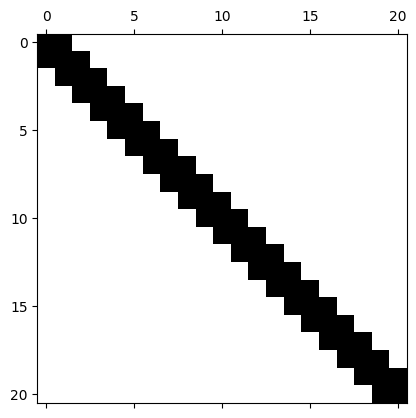

interactive(children=(FloatSlider(value=0.0, description='Final Time:', step=1.0), Output()), _dom_classes=('w…

In [3]:
# prompt: Assemble a a linear system for the heat equation above using the finite element method with Lagrange order 1 elements, using implicit Euler time stepping and a mesh resolution that is concentrated near the left boundary.

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from ipywidgets import interact, FloatSlider

# Define the domain and parameters
L = 10.0  # Length of the domain
n_elements = 20  # Number of elements
dt = 0.1  # Time step
t_final = 1.0  # Final time

# Create a mesh with concentration near the left boundary
x_nodes = np.concatenate((np.linspace(0, 2, int(n_elements / 2) + 1),
                          np.linspace(2 + (L - 2) / (n_elements / 2 - 1), L, int(n_elements / 2))))

# Define the element stiffness and mass matrices for linear elements
def element_stiffness(x1, x2):
    return np.array([[1, -1], [-1, 1]]) / (x2 - x1)

def element_mass(x1, x2):
    return np.array([[2, 1], [1, 2]]) * (x2 - x1) / 6

# Assemble the global stiffness and mass matrices
K = np.zeros((len(x_nodes), len(x_nodes)))
M = np.zeros((len(x_nodes), len(x_nodes)))

for i in range(len(x_nodes) - 1):
    x1 = x_nodes[i]
    x2 = x_nodes[i + 1]
    Ke = element_stiffness(x1, x2)
    Me = element_mass(x1, x2)
    K[i:i + 2, i:i + 2] += Ke
    M[i:i + 2, i:i + 2] += Me

plt.spy(M)
plt.show()

# Apply boundary conditions
# Dirichlet BC at x = L (T(L) = 0)
K[-1, :] = 0
K[-1, -1] = 1
M[-1, :] = 0
M[-1, -1] = 1

# Neumann BC at x = 0 (J(0) = 1)
# We'll implement this in the right-hand side vector later.

# Function to solve and plot for a given time
def solve_and_plot(t_final):
    T = np.zeros(len(x_nodes))
    t = 0.0
    while t < t_final:
        b = M @ T
        b[0] += dt * 1
        T = np.linalg.solve(M + dt * K, b)
        t += dt

    plt.plot(x_nodes, T)
    plt.xlabel('x')
    plt.ylim(-.5, 10)  # Set the y-axis limits to [0, 1]
    plt.ylabel('Temperature')
    plt.title('Temperature Profile at t = {}'.format(t_final))
    plt.show()


# Create a slider for the final time
time_slider = FloatSlider(value=0.0, min=0.0, max=100.0, step=1, description='Final Time:')

# Use interact to link the slider to the function
interact(solve_and_plot, t_final=time_slider);


Note that we could build the $M$ and $K$ matricies once, outside the time loop and reuse them for each time step! Even if we had adaptive time stepping, the matrix wouldn't change!

### Nonlinear case

If the PDE is nonlinear, we simply have to use a root finder. Note that in this case we are looking for the parameters $u_i$ directly - the shape functions are unaffected and therefore only the coefficients of the matrix *blocks* are altered. This brings up the concept of *sparsity patterns* which can help reduce the overhead of sparse matrix representaitons.

Since modern finite element software needs to construct the weak form, it is usually equiped with symbolic logic capabilities and therefore able to calculate the Jacobian.

#### Example: 1D nonlinear heat equation

Repeat the above exercise with $\lambda = 1 + u/10$

In [4]:
# prompt: Solve the heat transport problem again but this time with \lambda = 1+T/10

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from ipywidgets import interact, FloatSlider

# Define the domain and parameters
L = 10.0  # Length of the domain
n_elements = 20  # Number of elements
dt = 0.1  # Time step
t_final = 1.0  # Final time

# Create a mesh with concentration near the left boundary
x_nodes = np.concatenate((np.linspace(0, 2, int(n_elements / 2) + 1),
                          np.linspace(2 + (L - 2) / (n_elements / 2 - 1), L, int(n_elements / 2))))

# Define the element stiffness and mass matrices for linear elements
def element_stiffness(x1, x2, T):
    lambda_val = 1 + T / 10
    return np.array([[1, -1], [-1, 1]]) * lambda_val / (x2 - x1)


def element_mass(x1, x2):
    return np.array([[2, 1], [1, 2]]) * (x2 - x1) / 6

# Assemble the global stiffness and mass matrices
def assemble_matrices(T):
    K = np.zeros((len(x_nodes), len(x_nodes)))
    M = np.zeros((len(x_nodes), len(x_nodes)))

    for i in range(len(x_nodes) - 1):
        x1 = x_nodes[i]
        x2 = x_nodes[i + 1]
        Ke = element_stiffness(x1, x2, T[i:i+2].mean())
        Me = element_mass(x1, x2)
        K[i:i + 2, i:i + 2] += Ke
        M[i:i + 2, i:i + 2] += Me

    return K, M


# Apply boundary conditions
def apply_boundary_conditions(K, M):
    # Dirichlet BC at x = L (T(L) = 0)
    K[-1, :] = 0
    K[-1, -1] = 1
    M[-1, :] = 0
    M[-1, -1] = 1
    return K, M

# Function to solve and plot for a given time
def solve_and_plot(t_final):
    T = np.zeros(len(x_nodes))
    t = 0.0
    while t < t_final:
        K, M = assemble_matrices(T)
        K, M = apply_boundary_conditions(K, M)
        b = M @ T
        b[0] += dt * 1
        T = np.linalg.solve(M + dt * K, b)
        t += dt

    plt.plot(x_nodes, T)
    plt.xlabel('x')
    plt.ylim(-.5, 10)  # Set the y-axis limits to [0, 1]
    plt.ylabel('Temperature')
    plt.title('Temperature Profile at t = {}'.format(t_final))
    plt.show()


# Create a slider for the final time
time_slider = FloatSlider(value=0.0, min=0.0, max=100.0, step=1, description='Final Time:')

# Use interact to link the slider to the function
interact(solve_and_plot, t_final=time_slider);

interactive(children=(FloatSlider(value=0.0, description='Final Time:', step=1.0), Output()), _dom_classes=('w…

In [5]:
# prompt: Solve the heat transport problem again but this time with \lambda = 1+T/10 using a root finder don't copy any other text blocks

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.optimize import root
from ipywidgets import interact, FloatSlider


# Define the domain and parameters
L = 10.0  # Length of the domain
n_elements = 20  # Number of elements
dt = 0.1  # Time step
t_final = 1.0  # Final time

# Create a mesh with concentration near the left boundary
x_nodes = np.concatenate((np.linspace(0, 2, int(n_elements / 2) + 1),
                          np.linspace(2 + (L - 2) / (n_elements / 2 - 1), L, int(n_elements / 2))))

# Define the element stiffness and mass matrices for linear elements
def element_stiffness(x1, x2, lambda_val):
    return np.array([[1, -1], [-1, 1]]) * lambda_val / (x2 - x1)

def element_mass(x1, x2):
    return np.array([[2, 1], [1, 2]]) * (x2 - x1) / 6

# Assemble the global stiffness and mass matrices
M = np.zeros((len(x_nodes), len(x_nodes)))

for i in range(len(x_nodes) - 1):
    x1 = x_nodes[i]
    x2 = x_nodes[i + 1]
    Me = element_mass(x1, x2)
    M[i:i + 2, i:i + 2] += Me

# Apply boundary conditions
# Dirichlet BC at x = L (T(L) = 0)
M[-1, :] = 0
M[-1, -1] = 1

# Neumann BC at x = 0 (J(0) = 1)
# We'll implement this in the right-hand side vector later.

# Function to solve for T at the next time step using a root finder
def solve_for_next_T(T_prev):
    def residual(T):
        K = np.zeros((len(x_nodes), len(x_nodes)))
        for i in range(len(x_nodes) - 1):
            x1 = x_nodes[i]
            x2 = x_nodes[i + 1]
            lambda_val = 1 + T[i] / 10  # Update lambda based on T
            Ke = element_stiffness(x1, x2, lambda_val)
            K[i:i + 2, i:i + 2] += Ke

        b = M @ T_prev
        b[0] += dt * 1
        b[-1] = 0
        return (M @ T) + dt * (K @ T) - b

    sol = root(residual, T_prev)
    return sol.x

# Function to solve and plot for a given time
def solve_and_plot(t_final):
    T = np.zeros(len(x_nodes))
    t = 0.0
    while t < t_final:
        T = solve_for_next_T(T)
        t += dt

    plt.plot(x_nodes, T)
    plt.xlabel('x')
    plt.ylim(-.5, 10)
    plt.ylabel('Temperature')
    plt.title('Temperature Profile at t = {}'.format(t_final))
    plt.show()


# Create a slider for the final time
time_slider = FloatSlider(value=0.0, min=0.0, max=100.0, step=1, description='Final Time:')

# Use interact to link the slider to the function
interact(solve_and_plot, t_final=time_slider);

interactive(children=(FloatSlider(value=0.0, description='Final Time:', step=1.0), Output()), _dom_classes=('w…